# Climate Change Analysis 
* Student name: Chris Hollman
* Student pace: Self paced
* Scheduled review date/time: 
* Instructor name: Abhineet Kulkarni

## Buisiness Problem
An environmentally focused nonprofit organization is seeking data-focused insight to better understand climate change. This includes long term outlook and contributing factors. 

## Project Overview
The goal of this project is to study the trends of our global climate. This will include an analysis of historical data, a prediction of future values, and a regresssion model to determine major temperature predictors.

In [1]:
#importing necessarly tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
global_df = pd.read_csv('data/GlobalTemperatures.csv')
hist_gas_df = pd.read_csv('data/historical_emissions.csv')
gdp_df = pd.read_csv('data/gdp_growth.csv')
pop_df = pd.read_csv('data/world_population.csv')
forest_df = pd.read_csv('data/forest_area.csv')
oil_df = pd.read_csv('data/oil_consumption.csv')

## Initial Data Exploration for Timeseries Modeling
The first stage of this project will focus on changes on global temperature over time. We will build a model to identify trends in monthly temperature data, and eventually predict future temperature values.

There are columns for both land and land/ocean min, max, and average temperatures. The ocean temperatures seem to have not been recorded until around l00 years later than land temps. 

In [3]:
#Converting time stamp column to datetime format
global_df['dt'] = pd.to_datetime(global_df['dt'])

In [4]:
print("lowest uncertainty:", global_df['LandAverageTemperatureUncertainty'].min())
print("highest uncertainty:", global_df['LandAverageTemperatureUncertainty'].max())

lowest uncertainty: 0.034
highest uncertainty: 7.88


There is an extremely large difference in uncertainty as recording methods have become more sophisticated. The highest uncertaintly is +/- 7.88 degrees Celcius (14.8 degrees Farenheit). I've decided to trim the least accurate quartile of data.

In [5]:
global_df['LandAverageTemperatureUncertainty'].describe()

count    3180.000000
mean        0.938468
std         1.096440
min         0.034000
25%         0.186750
50%         0.392000
75%         1.419250
max         7.880000
Name: LandAverageTemperatureUncertainty, dtype: float64

In [6]:
#as expected, the uncertainty values for earlier dates tend to be on the high side
global_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#more recent temperatures are accurate within +/- two tenths of a degree Farenheit
global_df.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


In [8]:
#determining the latest month with an uncertainty greater than cutoff threshold
global_df[global_df['LandAverageTemperatureUncertainty']>1.4].tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1155,1846-04-01,7.473,1.729,NaN,NaN,NaN,NaN,NaN,NaN
1166,1847-03-01,4.046,1.583,NaN,NaN,NaN,NaN,NaN,NaN
1177,1848-02-01,3.726,1.437,NaN,NaN,NaN,NaN,NaN,NaN
1237,1853-02-01,2.228,1.492,8.29,1.535,-3.213,1.783,13.362,0.457
1260,1855-01-01,2.522,1.465,8.22,1.099,-3.125,1.699,13.384,0.442


In [9]:
#dropping all dates prior to 1856(the last year in which every recorded temp was within desired uncertainty range)
global_df = global_df[global_df['dt'] >= '1856']

In [10]:
#converting temps the Farenheit for interpretability
global_df['y'] = global_df['LandAverageTemperature']*1.8+32
global_df.rename(columns = {'dt':'ds'}, inplace = True)

## Prophet Model
Since there are no other obvious cleaning or preperation needed for our remaining data, we can start with a simple, useful model using NeuralProphet. This model calls for there to be only two columns, one with the datetime values that needs to be named 'ds' and one with the temperature values which needs to be named 'y'

In [11]:
#dropping unneccessary columns and formatting for Neural Prophet
drop_columns = ['LandAverageTemperature',
                'LandAverageTemperatureUncertainty',
                'LandMaxTemperature',
                'LandMaxTemperatureUncertainty',
                'LandMinTemperature',
                'LandMinTemperatureUncertainty',
                'LandAndOceanAverageTemperature',
                'LandAndOceanAverageTemperatureUncertainty']
ts = global_df.drop(drop_columns, axis=1)
ts.head()

,ds,y
1272,1856-01-01,36.9680
1273,1856-02-01,36.0068
1274,1856-03-01,39.8696
1275,1856-04-01,45.9518
1276,1856-05-01,50.9540


In [12]:
#taking a small sampple to take an initial look at the data
temp_1990_2000 = ts[ts['ds'].between('1990-01-01','2000-01-01')]
X = temp_1990_2000['ds']
y = temp_1990_2000['y']

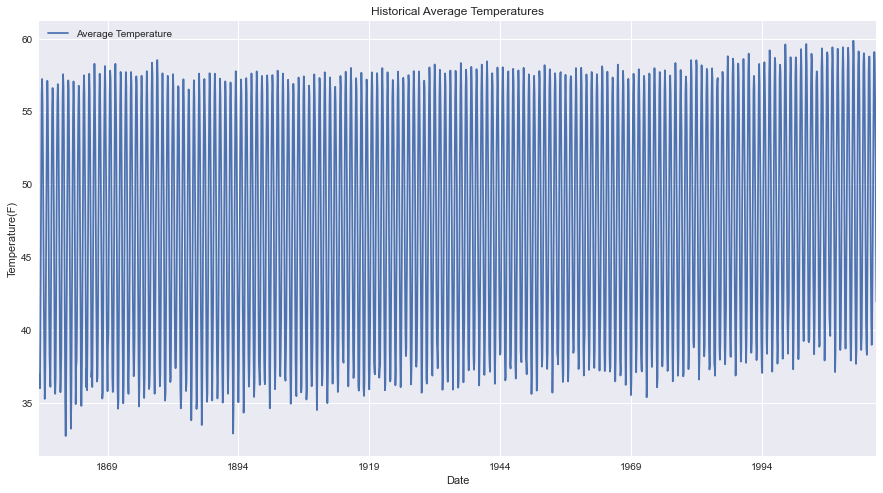

In [13]:
pd.plotting.register_matplotlib_converters()
ax = ts.set_index('ds').plot(figsize=(15, 8))
ax.set_title('Historical Average Temperatures')
ax.set_ylabel('Temperature(F)')
ax.set_xlabel('Date')
ax.legend(['Average Temperature']);

From this broad view, we can see that there is an slight overall upward trend. As expected there is yearly seasonality that the model should automatically pick up on.

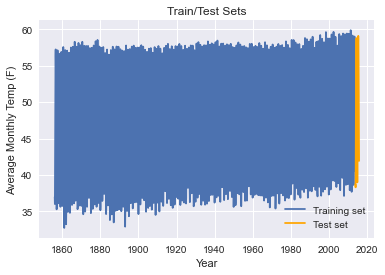

In [14]:
#splitting off last 2 years of data as a test set

ts_train = ts[ts['ds'] < pd.Timestamp('2014-01-01')]
ts_test = ts[ts['ds'] >= pd.Timestamp('2014-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(ts_train['ds'], ts_train['y'], label='Training set')
plt.plot(ts_test['ds'], ts_test['y'], label='Test set', color='orange')
plt.xlabel('Year')
plt.ylabel('Average Monthly Temp (F)')
plt.legend();

In [15]:
#checking test set dates
ts_test

,ds,y
3168,2014-01-01,38.7176
3169,2014-02-01,38.3000
3170,2014-03-01,43.4804
3171,2014-04-01,49.2602
3172,2014-05-01,54.6476
3173,2014-06-01,57.8030
3174,2014-07-01,58.7714
3175,2014-08-01,58.7750
3176,2014-09-01,55.5638
3177,2014-10-01,50.5940


### Intitial Modeling
The next step is to fit a NeuralProphet model to the timeseries. For the baseline model the only parameters we'll pass will be to prioritize MAE as the preferred metric to optimize. Once used to predict the test set, the model will return a validation MAE score as well as the components (trend and seasonality) applied to make the predictions. If the resulting MAE score is satisfactory, we can then broadcast those prediction out for future forecasts. For something as gradual as global temperature averages, we will try a longer term forecast of 30 years.

In [16]:
#fitting 'vanilla' NeuralProphet with MAE as loss function. 
m1 = NeuralProphet(loss_func='MAE')
m1.fit(ts_train, validation_df=ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.10E-02, min: 1.19E+00


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.49E-02, min: 1.79E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.16E-02
Epoch[160/160]: 100%|█| 160/160 [00:05<00:00, 27.73it/s, L1Loss=0.0193, MAE=0.48


,L1Loss,MAE,RMSE,Loss,RegLoss,L1Loss_val,MAE_val,RMSE_val
0,1.424897,35.691965,40.852027,1.081746,0.0,1.383941,34.666061,39.020642
1,1.303291,32.645871,37.896478,0.984459,0.0,1.251197,31.340977,35.779400
2,1.148677,28.772978,34.094686,0.861035,0.0,1.073594,26.892233,31.392531
3,0.950671,23.813179,29.003890,0.705014,0.0,0.850672,21.308314,25.749957
4,0.699414,17.519469,22.529463,0.507607,0.0,0.606793,15.199444,19.413364
...,...,...,...,...,...,...,...,...
155,0.019540,0.489447,0.641359,0.014235,0.0,0.347513,8.704784,10.747031
156,0.019411,0.486216,0.636823,0.014153,0.0,0.347575,8.706343,10.748567
157,0.019297,0.483357,0.632118,0.014073,0.0,0.347574,8.706305,10.748478
158,0.019283,0.483017,0.633052,0.014060,0.0,0.347503,8.704544,10.746559


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


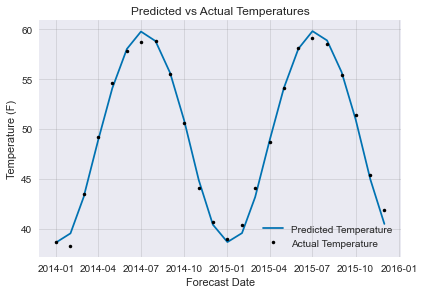

In [17]:
#plotting forcasted vs actual temperatures for test set
forecast1 = m1.predict(ts_test)
ax = plt.subplot()
plot= m1.plot(forecast1, ax = ax)
ax.set_title('Predicted vs Actual Temperatures')
ax.set_xlabel('Forecast Date')
ax.set_ylabel('Temperature (F)')
ax.legend(['Predicted Temperature', 'Actual Temperature']);

In [18]:
#forecast table
forecast1

,ds,y,residual1,yhat1,trend,season_yearly
0,2014-01-01,38.7176,-0.067022,38.650578,49.422318,-10.771738
1,2014-02-01,38.3000,1.270644,39.570644,49.426224,-9.855580
2,2014-03-01,43.4804,-0.282795,43.197605,49.429756,-6.232152
3,2014-04-01,49.2602,-0.348567,48.911633,49.433666,-0.522035
4,2014-05-01,54.6476,-0.550253,54.097347,49.437450,4.659897
5,2014-06-01,57.8030,0.221086,58.024086,49.441360,8.582726
6,2014-07-01,58.7714,0.995965,59.767365,49.445145,10.322219
7,2014-08-01,58.7750,0.038118,58.813118,49.449051,9.364065
8,2014-09-01,55.5638,0.064458,55.628258,49.452965,6.175294
9,2014-10-01,50.5940,0.264448,50.858448,49.456745,1.401702


In [19]:
#calculation MAE for test set
mean_absolute_error(forecast1['y'], forecast1['yhat1'])

0.46376712799072334

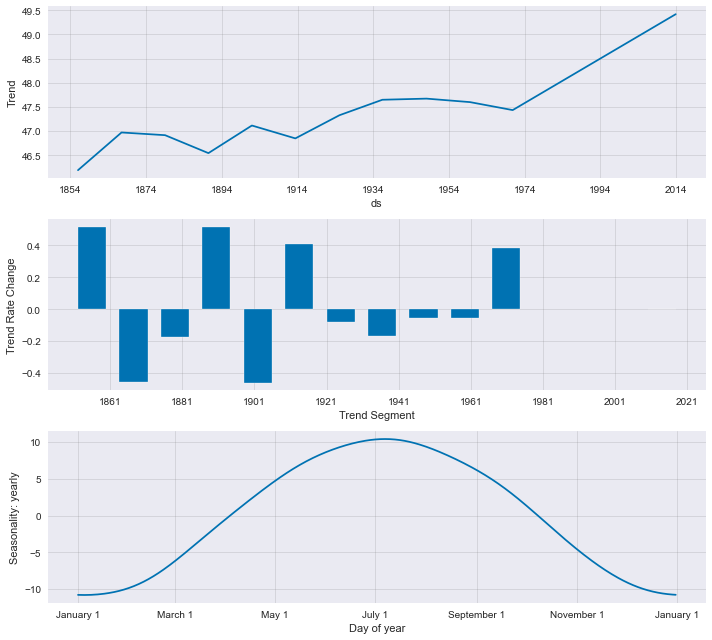

In [20]:
#plotting trend and seasonality components
params = m1.plot_parameters()

#### Model Interpretation
This model is performing very well with a MAE of 0.46. It is important to remember that it is only predicting one month into the future. In other words, it's unlikely that the forecast based on this data will be within .5 degrees when predicting the long term future. The only parameter I'd like to tweak is changepoint range, which is set at .8 by default, meaning that the model will not pick up on any change in trend in the last 20% of data, or around th 1970's. If you look at the trend portion of the parameters plot, this is where a significant upward trend begins. Before predicting future values, we will include all but the last 10%, identify whether this decreases the MAE, and then use the best performing parameters to predict future temperatures. 

### Second Prophet Model

In [21]:
#fitting new Prophet model with larger changepoint range
m2 = m1 = NeuralProphet(loss_func='MAE', changepoints_range =.9)
m2.fit(ts_train, validation_df=ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-01, min: 5.04E-02


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.33E-01, min: 4.30E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.25E-01
Epoch[160/160]: 100%|█| 160/160 [00:05<00:00, 28.78it/s, L1Loss=0.0193, MAE=0.48


,L1Loss,MAE,RMSE,Loss,RegLoss,L1Loss_val,MAE_val,RMSE_val
0,0.899753,22.537738,31.358314,0.631363,0.0,0.851123,21.319619,27.625312
1,0.680569,17.047433,24.018141,0.468816,0.0,0.689700,17.276161,21.239678
2,0.484766,12.142814,16.492931,0.320431,0.0,0.491729,12.317218,14.866129
3,0.266851,6.684307,9.429228,0.162579,0.0,0.414503,10.382790,12.782523
4,0.144762,3.626124,5.594450,0.085705,0.0,0.380322,9.526609,11.742250
...,...,...,...,...,...,...,...,...
155,0.019856,0.497374,0.649986,0.014450,0.0,0.347706,8.709617,10.751812
156,0.019637,0.491887,0.640421,0.014323,0.0,0.348043,8.718070,10.762064
157,0.019527,0.489121,0.639649,0.014228,0.0,0.347118,8.694881,10.734627
158,0.019405,0.486084,0.638282,0.014113,0.0,0.347362,8.700996,10.742184


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


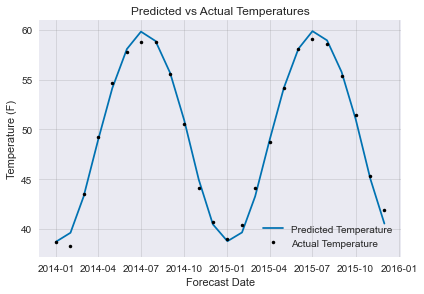

In [22]:
#plotting forecasted vs actual temperatures for test set
forecast2 = m2.predict(ts_test)
ax = plt.subplot()
plot= m2.plot(forecast2, ax = ax)
ax.set_title('Predicted vs Actual Temperatures')
ax.set_xlabel('Forecast Date')
ax.set_ylabel('Temperature (F)')
ax.legend(['Predicted Temperature', 'Actual Temperature']);

In [23]:
#calculating mae for test set
mean_absolute_error(forecast2['y'], forecast2['yhat1'])

0.45699523468017605

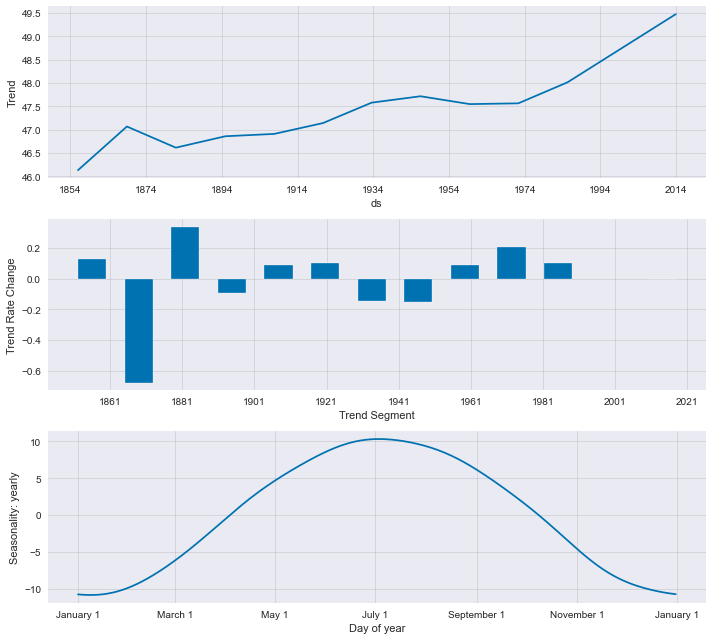

In [83]:
#plotting trend and seasonality for second model
params2 = m2.plot_parameters()

#### Second Model Interpretation/Predictions
Since this parameter change resulted in better scores, we will use this model to predict future global temperatures. Since global temperature change is seems to occur over longer timespans, we will have our model predict temps over the next 30 years.  

In [25]:
#creating a dataframe of future dates
future_dates = m2.make_future_dataframe(periods = 360, df = ts_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [26]:
#predicting future temperatures values
forecast_future = m2.predict(future_dates)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


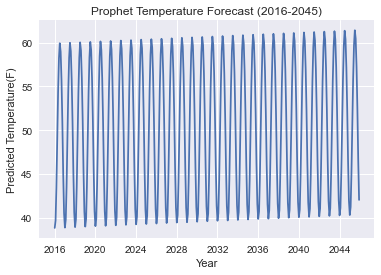

In [89]:
#plotting predictions
plt.plot(forecast_future['ds'], forecast_future['yhat1']);
plt.xlabel('Year')
plt.ylabel('Predicted Temperature(F)')
plt.title('Prophet Temperature Forecast (2016-2045)');

In [28]:
#grouping forcasts by yearly average
forecast_future.groupby(pd.Grouper(key="ds", freq="Y")).mean()

,yhat1,trend,season_yearly
ds,,,
2016-12-31,49.562247,49.604182,-0.041936
2017-12-31,49.618573,49.655234,-0.036662
2018-12-31,49.669372,49.706262,-0.036891
2019-12-31,49.720172,49.757292,-0.037120
2020-12-31,49.766501,49.808436,-0.041936
2021-12-31,49.822827,49.859489,-0.036662
2022-12-31,49.873626,49.910516,-0.036891
2023-12-31,49.924425,49.961545,-0.037120
2024-12-31,49.970754,50.012690,-0.041936


### Prophet Summary
The final Prophet model also picked up on a significant upward trend beginning in the 1970's. With a one month lag, the model is performing well, with a MAE of .459. The model suggests that global average temperatures will increase by another 1.5 degrees over the next 30 years. This is roughly on par with the predictions from the U.S. Global Change Research Program's 2016 Climate Science Special Report, which predicts an increase of 2 to 4 degrees by mid 21st century (2036-2065), depending on a number of factors.

## LSTM Model
Next we will apply and LSTM (Long Short Term Memory) Model to the same timeseries data. This is a bit more involved than Prophet, which automates many of the following steps. 
1. This model requires a slightly different datafram structure than our Prophet model (DateTime Index)
2. Resplitting into 2 year test set
3. Scaling the data (happens automatically with prophet)

In [29]:
#reformatting DataFrame
lstm_df = ts.set_index('ds')
lstm_df.head()

,y
ds,
1856-01-01,36.9680
1856-02-01,36.0068
1856-03-01,39.8696
1856-04-01,45.9518
1856-05-01,50.9540


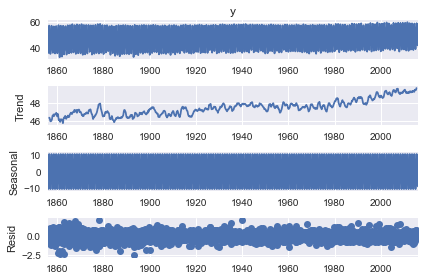

In [30]:
#plotting a second look at trend and seasonality
results = seasonal_decompose(lstm_df['y'])
results = results.plot()

We can see the same general trend that the prophet model picked up on. The seasonality is tougher to make out but has been well covered earlier in the notebook as well. We do not need to check for stationarity, as these more complex models don't require a stationary dataset. 

In [31]:
#splitting last 2 years for test set
lstm_train = lstm_df[lstm_df.index < pd.Timestamp('2014-01-01')]
lstm_test = lstm_df[lstm_df.index >= pd.Timestamp('2014-01-01')]

In [32]:
#min-max scaling data
scaler = MinMaxScaler()
scaler.fit(lstm_train)
train_scaled = scaler.transform(lstm_train)
test_scaled = scaler.transform(lstm_test)

### Building LSTM Model
We can now build a simple LSTM Model to see how it performs as compared to Prophet. We will have the model make predictions 1 month into the future based on values from the last 6 months. The model itself will be composed of an LSTM layer with relu activation, as well as a dense layer. As before the model will optimize based on MAE. 

In [33]:
#establishing parameters and formatting data for model
n_input = 6
n_features = 1 
generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_input, batch_size = 1)

In [34]:
#adding layers
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

Metal device set to: Apple M1


2022-11-17 08:55:40.745792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 08:55:40.745907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
#summary of model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [36]:
#fitting to data
model.fit(generator, epochs=30)

Epoch 1/30


2022-11-17 08:55:40.891521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 08:55:41.377315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1890/1890 [==============================] - 76s 40ms/step - loss: 0.0859
Epoch 2/30
1890/1890 [==============================] - 82s 43ms/step - loss: 0.0388
Epoch 3/30
1890/1890 [==============================] - 87s 46ms/step - loss: 0.0347
Epoch 4/30
1890/1890 [==============================] - 89s 47ms/step - loss: 0.0312
Epoch 5/30
1890/1890 [==============================] - 92s 48ms/step - loss: 0.0299
Epoch 6/30
1890/1890 [==============================] - 82s 43ms/step - loss: 0.0289
Epoch 7/30
1890/1890 [==============================] - 93s 49ms/step - loss: 0.0280
Epoch 8/30
1890/1890 [==============================] - 89s 47ms/step - loss: 0.0278
Epoch 9/30
1890/1890 [==============================] - 92s 49ms/step - loss: 0.0272
Epoch 10/30
1890/1890 [==============================] - 91s 48ms/step - loss: 0.0271
Epoch 11/30
1890/1890 [==============================] - 91s 48ms/step - loss: 0.0267
Epoch 12/30
1890/1890 [==============================] - 81s 43ms/step - l

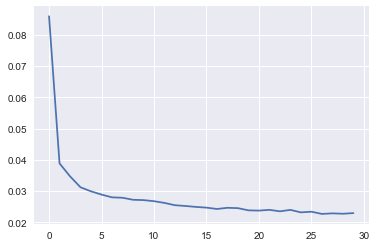

In [37]:
#plotting loss to make sure model performance has hit a plateau
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [38]:
#formatting data for predictions
last_train_batch = train_scaled[-6:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [39]:
#testing
model.predict(last_train_batch)

1/1 [==============================] - 0s 206ms/step


2022-11-17 09:38:43.333737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.1749605]], dtype=float32)

In [40]:
#viewing prediction to verify that model is working correctly
test_scaled[0]

array([0.22071893])

In [41]:
#predicting test data
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(lstm_test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 15ms/step


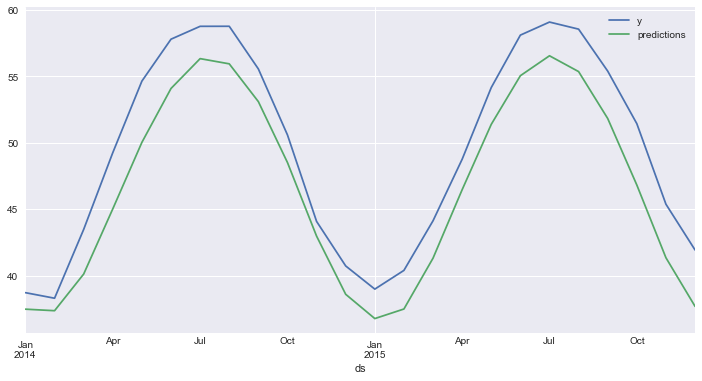

In [42]:
#scaling predictions back to original Farenheit values and plotting vs actual test values
final_predictions = scaler.inverse_transform(test_predictions)
lstm_test['predictions'] = final_predictions
lstm_test.plot(figsize=(12,6)); 

In [43]:
#calculating mae for lstm model
mean_absolute_error(lstm_test['y'], lstm_test['predictions'])

2.891437440211329

### LSTM Model Interpretation
This model performed very poorly as compared to the Prophet model, with a MAE of 2.89. It also took significantly longer to run. 

### LSTM Summary 
The LSTM model performed poorly as compared to the Prophet model and was far more expensive computationally. With this in mind i've chosen not to forecast future temperatures with this model

## Regression Model Using XGBoost
The last step in this project will be to run a regression model that takes possible contributers to climate change into account. We will use XG boost for this step and will introduce some factors commonly accepted to contribute to climate change. The data we will use covers global:
1. Co2 Emissions (MTCO2e)
2. Oil Consumption(TWh)
3. Forest Area(Percentage of Land Area)
4. GDP(Growth Rate)
5. Population

We will use these values to predict average temperature for a particular year, look at correlations, and determine which factors are most useful to the model in making temperature predictions.  

### Cleaning/Preproccessing 
Before we do any modeling, we will need all of these dataframes converted to the same format with a datetime index in year intervals along with the value for that year. Below I've completed these steps.

In [44]:
#formatting yearly temp data
temp_year_df = ts.groupby(pd.Grouper(key="ds", freq="Y")).mean().reset_index()
temp_year_df['ds'] = temp_year_df['ds'].dt.year

In [45]:
temp_year_df.set_index('ds', inplace = True)
temp_year_df.head()

,y
ds,
1856,46.39265
1857,45.96470
1858,46.58045
1859,46.85360
1860,46.32950


In [46]:
#formatting forest area data
for_drop_cols = ['Code', 'Entity']
forest_df = forest_df[forest_df['Entity'] == 'World'].set_index('Year')
forest_df = forest_df.drop(columns = for_drop_cols)
forest_df.head()

,Forest cover
Year,
1990,32.518625
1991,32.458458
1992,32.398291
1993,32.338124
1994,32.277957


In [47]:
#formatting global oil consmption data
oil_drop_cols = ['Entity','Code']
oil_df = oil_df[oil_df['Entity'] == 'World']
oil_df = oil_df.drop(columns=oil_drop_cols).set_index('Year')
oil_df.head()

,Oil Consumption - TWh
Year,
1965,17989.603516
1966,19341.146484
1967,20732.136719
1968,22488.332031
1969,24353.000000


In [48]:
#formatting global greenhouse gas emmissions data
gas_drop_columns = ['Country', 'Sector','Data source', 'Gas', 'Unit']
gas_df = hist_gas_df[hist_gas_df['Country'] == 'World'].drop(columns = gas_drop_columns).transpose()
gas_df.index = pd.to_datetime(gas_df.index)
gas_df.index = gas_df.index.year
gas_df.head()

,0
2018,36441.55
2017,35588.70
2016,35160.60
2015,34521.91
2014,34558.59


In [49]:
#formatting global population data
pop_df = pop_df[pop_df['Entity'] == 'World']
pop_df = pop_df[pop_df['Year'].between(1990,2018)]
pop_drop_cols = ['Code', 'Entity']
pop_df = pop_df.drop(columns=pop_drop_cols).set_index('Year')
pop_df.head()

,Population
Year,
1990,5316175872
1991,5406245888
1992,5492686336
1993,5577433600
1994,5660727808


In [50]:
#formatting global GDP growth rate data
gdp_drop_columns = ['Code', 'Country Name']
world_gdp = gdp_df[gdp_df['Country Name'] == "World"].drop(columns=gdp_drop_columns).transpose()
world_gdp = world_gdp.dropna()
world_gdp.index = pd.to_datetime(world_gdp.index)
world_gdp.index = world_gdp.index.year
world_gdp.head()

,259
1961,3.800832
1962,5.320280
1963,5.192421
1964,6.568749
1965,5.555097


In [65]:
#joining dataframes 
reg_df = pop_df.join(world_gdp).join(gas_df).join(temp_year_df).join(forest_df).join(oil_df)

#renaming columns
mapping = {
    reg_df.columns[0]:'Population',
    reg_df.columns[1]: 'GDP Growth', 
    reg_df.columns[2]:'Emissions', 
    reg_df.columns[3]: 'Average Temp', 
    reg_df.columns[4]: 'Forest Cover', 
    reg_df.columns[5]: 'Oil Consumption'
}

reg_df.rename(columns = mapping, inplace=True)

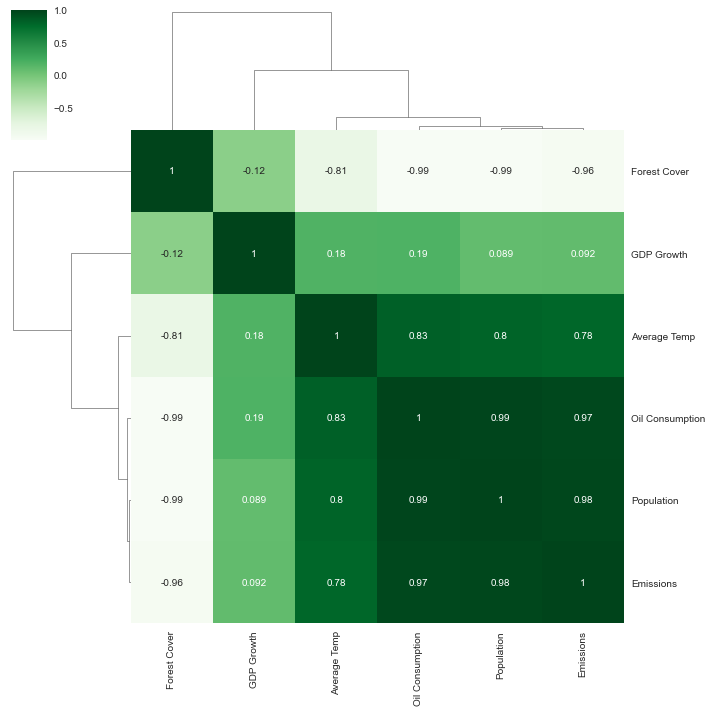

In [66]:
#dropping na values and looking at correlation
reg_df = reg_df.dropna()
corr_matrix = reg_df.corr()
sns.clustermap(corr_matrix, cmap = 'Greens', annot = True);

In [92]:
reg_df = reg_df.drop(columns='GDP Growth')

Strong correlation is present in these values, the strongest being negative correlations between forest cover and population/oil consumption. Oil consumption has the strongest correlation with average temperatures.

In [91]:
reg_df['Average Temp'].describe()

count    26.000000
mean     48.907908
std       0.469798
min      47.905850
25%      48.578862
50%      49.043300
75%      49.209688
max      49.695800
Name: Average Temp, dtype: float64

In [93]:
#performing train-test split
X = reg_df.drop('Average Temp', axis=1)
y = reg_df['Average Temp']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .15, random_state=6)

### Building XGBoost Model
Next we will perform a grid search to see which parameters perform best using MAE as the metric to optimize

In [98]:
#creating parameter grid search for XGBoost Regressor
boost = XGBRegressor()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3,4,5,6],
    'min_child_weight': [1, 2, 3],
    'n_estimators': [100,200]
}

In [99]:
#performing grid search to optimize MAE
grid_boost = GridSearchCV(
    boost, 
    param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    n_jobs=1)
grid_boost.fit(X_train, y_train)

best_parameters = grid_boost.best_params_

for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_boost.predict(X_train)
test_preds = grid_boost.predict(X_test)
training_MAE = mean_absolute_error(y_train, training_preds)
test_MAE = mean_absolute_error(y_test, test_preds)
#printing results
print('')
print('Training MAE:' ,training_MAE)
print('Validation MAE:' ,test_MAE)

learning_rate: 0.1
max_depth: 3
min_child_weight: 3
n_estimators: 100

Training MAE: 0.12645060452548018
Validation MAE: 0.4382044967651346


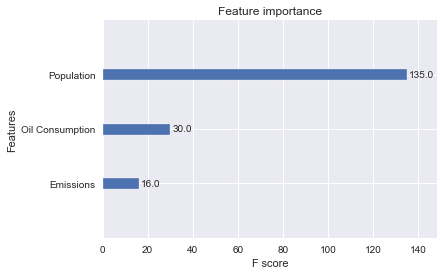

In [101]:
#fitting final model and identifying most important features
final_XGB = XGBRegressor(learning_rate=0.1, 
                         max_depth=3, 
                         min_child_weight=3, 
                         n_estimators = 100)

final_XGB.fit(X_train, y_train);
xgboost.plot_importance(final_XGB);

# Regression Summary
The regression model was able to perform very well, predicting a given year based on the other values with an MAE score of .43 for the validation data. The most useful features for our tuned model were:
1. Population (135)
2. Oil Consumption (30)
3. Emissions (16)

Due to the stochastic nature of this model, future results may vary.


## Conclusions
Based on the results of the models, the following insights stand out:
#### Temperature is trending upwards, especially after 1970 
This coincides with the beginning of automated production lines and mass production

#### There is significant correlation between population, emissions, average temp, oil consumption, and deforestation
These values suggest that the world population is growing and consuming more fossil fuels on a year to year basis. This increase doesn't neccesarily coincide with a larger GDP.

####   Population, Oil Consumption, and Emissions are strong predictors of temperature
While association does not equate to causation, these factors can be used to effectively predict average yearly temperatures.

## Next Steps
#### Further insight into emmissions
Since moslt likely don't immediately affect temperature, it would be interesting to explore different lag periods to discover any sort of delay of cumulative effect that emissions have on global temperatures. 

#### Population Studies
Since population size seems to be a major contributor to rising global temperatures, comparing country population, growth rates, and consumption/emmissions of those countries may lead to ways to minimize the environmental impact of a growing population.

#### Seasonality Studies
According to experts, the general trend of warming is likely to be accompanied by wider temperature swings and more extreme weather. Looking into shorter term weather data such as monthly highs, lows, and extreme weather events for smaller geograpgical areas would add more specific context to this study.